In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.stats import norm

In [3]:
def generate_normal_series(number, mean):
    data = []
    labels = []
    for i in range(number):
        x = []
        label = []
        x_prev = 0
        coef = 0.75
        length = scipy.stats.randint.rvs(50, 200)
        for l in range(length):
            x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean, scale=1)
            x.append(x_curr)
            x_prev = x_curr
            label.append(0)
        data.append(np.asarray(x))
        labels.append(np.asarray(label))
    return data, labels

In [4]:
number_normal = 1000
data_normal, labels_normal = generate_normal_series(number_normal, 0)

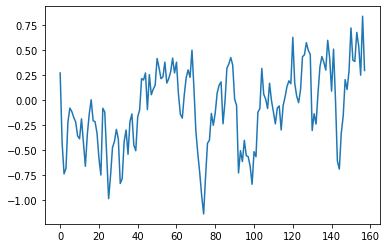

In [5]:
plt.plot(data_normal[0])

In [6]:
def generate_anomaly_series(number, mean_old, mean_new):
    data = []
    labels = []
    for i in range(number):
        x = []
        label = []
        x_prev = 0
        coef = 0.75
        length = scipy.stats.randint.rvs(50, 200)
        chane_point = scipy.stats.randint.rvs(10, length-20)
        for l in range(length):
            if l < chane_point:
                x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean_old, scale=1)
                label.append(0)
                
            else:
                x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean_new, scale=1)
                label.append(1)
            x.append(x_curr)
            x_prev = x_curr
        data.append(np.asarray(x))
        labels.append(np.asarray(label))
    return data, labels

In [7]:
number_anomaly = 200
data_anomaly, labels_anomaly = generate_anomaly_series(number_anomaly, 0, 5)

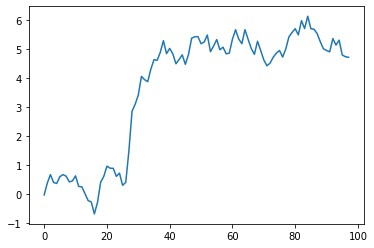

In [8]:
plt.plot(data_anomaly[0])

In [9]:
def loss_delay_detection(p_slice):
    length = len(p_slice)
    loss = 0
    for i in range(length):
        loss += (i+1)*p_slice[i] * torch.prod((torch.ones(i).float()-p_slice[:i]))
    return loss

def loss_false_alarms_i(p_slice):
    length = len(p_slice)
    loss = 0
    for i in range(length):
        loss += p_slice[i] * torch.prod((torch.ones(i).float()-p_slice[:i]))
    return loss

def loss_false_alarms(p_slice, l = 4):
    length = len(p_slice)
    loss = 0
    for i in range(0, l):
        ind = i*(length//l)
        loss += loss_false_alarms_i(p_slice[ind: ind + length//l])
    loss = torch.sum(loss)
    return loss

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(1)

In [11]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.empty(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.nonzero(label[1:] != label[:1]) 
            if ind.size()[0] == 0:
                if label[0] == 0:
                    loss[i] = loss_false_alarms(outputs[i, :])
                else:
                    #loss[i] = loss_false_alarms(torch.ones(len(outputs)).float() - outputs[i, :])     
                    loss[i] = loss_delay_detection(outputs[i, :])
            else:
                loss[i] = loss_delay_detection(outputs[i, ind[0]:])
        loss = torch.mean(loss)
        return loss

In [12]:
all_ts_data = np.asarray(data_normal + data_anomaly)
all_labels = np.asarray(labels_normal + labels_anomaly)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
ts_train, ts_test, label_train, label_test = train_test_split(all_ts_data, all_labels, 
                                                              test_size=0.25, shuffle=True,
                                                              random_state=42)

In [15]:
def create_sequences(ts, label, tw):
    inout_seq = []
    for t in range(len(ts)):
        curr_ts = torch.FloatTensor(ts[t]).view(-1)
        curr_label = torch.IntTensor(label[t]).view(-1)
        for i in range(len(curr_ts) - tw):
            train_seq = curr_ts[i:i+tw]
            train_label = curr_label[i:i+tw]
            inout_seq.append((train_seq ,train_label))
    return inout_seq

In [16]:
train_inout_seq = create_sequences(ts_train, label_train, 32)
val_inout_seq = create_sequences(ts_test, label_test, 32)

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear = nn.Linear(hidden_dim, output_size)
        self.activation = nn.Sigmoid()
        
    #    self.reset_parameters()

    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq[:, None, :], hidden)        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)        

        out = self.dropout(lstm_out)
        out = self.linear(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden
    
    #def reset_parameters(self):
    #    init_range = 0.025
    #    for param in self.parameters():
    #        param.data.uniform(-init_range, init_range)

In [18]:
train_inout_seq = train_inout_seq[:-(len(train_inout_seq)%32)]
val_inout_seq = val_inout_seq[:-(len(val_inout_seq)%32)]

In [19]:
model = LSTM(input_size=32, output_size=32, hidden_dim=2, n_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = CustomLoss()

In [20]:
device = torch.device("cpu")

In [21]:
len(train_inout_seq)

83040

In [22]:
from tqdm.notebook import tqdm

In [23]:
train_loader = DataLoader(train_inout_seq, batch_size=32, shuffle=True, num_workers=1)
val_loader = DataLoader(val_inout_seq, batch_size=32, shuffle=True, num_workers=1)

In [24]:
epochs = 5
counter = 0
print_every = 500
clip = 5
valid_loss_min = np.Inf

output_size = 32
hidden_dim = 2
n_layers = 2
batch_size=32

loss_list = []
acc_list = []
counter = 0
model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, labels in tqdm(train_loader):
        
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)        
        model.zero_grad()
        optimizer.zero_grad()
        output, h = model(inputs, h)
        loss = loss_function(output.squeeze(), labels.float())
        
        loss_list += [loss.clone().detach()]
        accuracy = (output > 0.5).long() == labels
        acc_list += [accuracy.detach().float().mean()]
        
        loss.backward()
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for val_inputs, val_labels in val_loader:
                val_h = tuple([each.data for each in val_h])
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                
                val_out, val_h = model(val_inputs, val_h)
                val_loss = loss_function(val_out.squeeze(), val_labels.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
        

Epoch: 1/5... Step: 500... Loss: 2.024462... Val Loss: 1.898946
Epoch: 1/5... Step: 1000... Loss: 1.932155... Val Loss: 1.889946
Epoch: 1/5... Step: 1500... Loss: 1.947137... Val Loss: 1.887418
Epoch: 1/5... Step: 2000... Loss: 1.976451... Val Loss: 1.886645
Epoch: 1/5... Step: 2500... Loss: 1.909718... Val Loss: 1.886233



Epoch: 2/5... Step: 3000... Loss: 1.908723... Val Loss: 1.884927
Epoch: 2/5... Step: 3500... Loss: 1.907467... Val Loss: 1.884694
Epoch: 2/5... Step: 4000... Loss: 1.877903... Val Loss: 1.884586
Epoch: 2/5... Step: 4500... Loss: 1.753515... Val Loss: 1.884348
Epoch: 2/5... Step: 5000... Loss: 1.845076... Val Loss: 1.883092



Epoch: 3/5... Step: 5500... Loss: 1.937787... Val Loss: 1.883014
Epoch: 3/5... Step: 6000... Loss: 1.938019... Val Loss: 1.882983
Epoch: 3/5... Step: 6500... Loss: 1.938226... Val Loss: 1.882954
Epoch: 3/5... Step: 7000... Loss: 1.906489... Val Loss: 1.881554
Epoch: 3/5... Step: 7500... Loss: 1.875150... Val Loss: 1.881460



Epoch: 4/5... Step: 8000... Loss: 1.937700... Val Loss: 1.881435
Epoch: 4/5... Step: 8500... Loss: 1.843861... Val Loss: 1.881422
Epoch: 4/5... Step: 9000... Loss: 1.906325... Val Loss: 1.881406
Epoch: 4/5... Step: 9500... Loss: 1.906307... Val Loss: 1.880051
Epoch: 4/5... Step: 10000... Loss: 1.781329... Val Loss: 1.879920



Epoch: 5/5... Step: 10500... Loss: 1.021204... Val Loss: 0.971493
Epoch: 5/5... Step: 11000... Loss: 0.974638... Val Loss: 0.968186
Epoch: 5/5... Step: 11500... Loss: 0.970067... Val Loss: 0.967846
Epoch: 5/5... Step: 12000... Loss: 0.906896... Val Loss: 0.967728
Epoch: 5/5... Step: 12500... Loss: 1.000995... Val Loss: 0.967667



In [50]:
labels[15]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)

In [51]:
output[15]

tensor([9.9995e-01, 9.9889e-01, 9.9900e-01, 9.9916e-01, 9.9902e-01, 9.9914e-01,
        9.9922e-01, 6.5750e-01, 1.4652e-03, 9.3754e-04, 1.8326e-04, 3.7361e-05,
        1.1585e-05, 4.5691e-06, 2.9444e-06, 3.1153e-06, 3.0159e-06, 2.5314e-06,
        2.4452e-06, 2.7916e-06, 1.5861e-06, 4.1043e-06, 2.0066e-06, 3.5962e-06,
        2.8360e-06, 3.8374e-06, 2.4639e-06, 1.2829e-06, 3.2625e-06, 2.6232e-06,
        2.3432e-06, 1.9031e-06], grad_fn=<SelectBackward>)

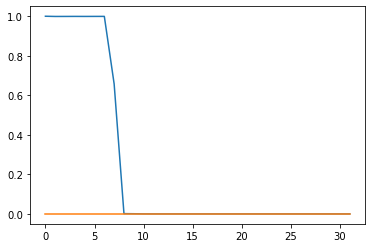

In [29]:
plt.plot(output[2].detach().numpy())
plt.plot(labels[2].detach().numpy())

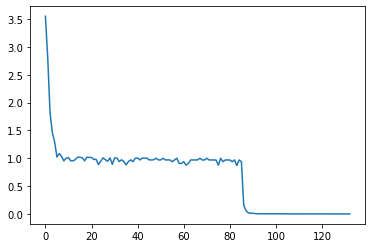

In [27]:
plt.plot(loss_list[::100])
plt.savefig('right_loss2.png', dpi=500, facecolor='w')

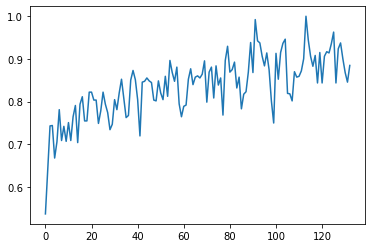

In [36]:
plt.plot(acc_list[::100])

In [34]:
test_number_normal = 500
test_data_normal, test_labels_normal = generate_normal_series(test_number_normal, 0)

test_number_anomaly = 500
test_data_anomaly, test_labels_anomaly = generate_anomaly_series(test_number_anomaly, 0, 5)

test_data = np.asarray(test_data_normal + test_data_anomaly)
test_labels = np.asarray(test_labels_normal + test_labels_anomaly)

In [35]:
test_inout_seq = create_sequences(test_data, test_labels, 32)
test_inout_seq = test_inout_seq[:-(len(test_inout_seq)%64)]
test_loader = DataLoader(test_inout_seq, batch_size=32, shuffle=True, num_workers=1)

In [37]:
test_loss_list = []
test_acc_list = []
test_h = model.init_hidden(batch_size)

model.eval()
for test_inputs, test_labels in test_loader:
    test_h = tuple([each.data for each in test_h])
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
    test_output, test_h = model(test_inputs, test_h)
    test_loss = loss_function(test_output.squeeze(), test_labels.float())
    test_loss_list += [test_loss.clone().detach()]
    accuracy = (test_output > 0.5).long() == test_labels
    test_acc_list += [accuracy.detach().float().mean()]

print("Test loss: {:.3f}".format(np.mean(test_loss_list)))
print("Test accuracy: {:.3f}%".format(np.mean(test_acc_list)))

Test loss: 0.000
Test accuracy: 0.727%


## Baseline

In [ ]:
def prepare_data_for_baseline(data_inout_seq):
    new_data = []
    for data, labels in data_inout_seq:
        if labels.sum() == 0:
            new_data.append((data, torch.FloatTensor([0])))
        else:
            new_data.append((data, torch.FloatTensor([1])))
    return new_data

In [ ]:
train_data = prepare_data_for_baseline(train_inout_seq)
val_data = prepare_data_for_baseline(val_inout_seq)
test_data = prepare_data_for_baseline(test_inout_seq)

In [ ]:
new_train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=1)
new_val_loader = DataLoader(val_data, batch_size=32, shuffle=True, num_workers=1)
new_test_loader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=1)

In [ ]:
from torch.nn import BCELoss

In [ ]:
model = LSTM(input_size=32, output_size=1, hidden_dim=2, n_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = BCELoss()

In [ ]:
epochs = 5
counter = 0
print_every = 500
clip = 5
valid_loss_min = np.Inf

output_size = 1
hidden_dim = 2
n_layers = 2
batch_size=32

loss_list = []
acc_list = []
counter = 0
model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, labels in tqdm(new_train_loader):
        
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)        
        model.zero_grad()
        optimizer.zero_grad()
        output, h = model(inputs, h)
        loss = loss_function(output.squeeze(), labels.squeeze())
        
        loss_list += [loss.clone().detach()]
        accuracy = (output > 0.5).long() == labels
        acc_list += [accuracy.detach().float().mean()]
        
        loss.backward()
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for val_inputs, val_labels in new_val_loader:
                val_h = tuple([each.data for each in val_h])
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                
                val_out, val_h = model(val_inputs, val_h)
                val_loss = loss_function(val_out.squeeze(), val_labels.squeeze())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

In [ ]:
loss_list = []
acc_list = []
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in new_test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = loss_function(output.squeeze(), labels.squeeze())
    loss_list += [test_loss.clone().detach()]
    accuracy = (output > 0.5).long() == labels
    acc_list += [accuracy.detach().float().mean()]

print("Test loss: {:.3f}".format(np.mean(loss_list)))
print("Test accuracy: {:.3f}%".format(np.mean(acc_list)))